<a href="https://colab.research.google.com/github/GutlapalliNikhil/ImageClassification_on_CIFAR10/blob/main/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEl"] = "3"

import tensorflow as tf
print(tf.__version__)

2.7.0


In [3]:
if not os.path.exists("helper_functions.py"):
  print("Downloading python file")
  !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
  print("Already Present, so skipping..")

--2022-02-04 11:11:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-02-04 11:11:11 (61.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves

In [5]:
import tensorflow_datasets as tfds

In [6]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 

Another way of downloading dataset

from tensorflow.keras.datasets import cifar10
(train_image, train_label), (test_image, test_label) = cifar10.load_data()

In [7]:
(train_data, test_data), ds_info = tfds.load(name="cifar10",
                                             split=["train", "test"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info= True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete4P5DJ7/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete4P5DJ7/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [8]:
ds_info.features

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

In [9]:
class_names = ds_info.features["label"].names
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [10]:
train_one_sample = train_data.take(1)

In [11]:
train_one_sample

<TakeDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>

In [12]:
for image, label in train_one_sample:
  print(f"""
  Image Shape - {image.shape}
  Image Dtype - {image.dtype}
  Target class - {label}
  Target label - {class_names[label]}
  """)


  Image Shape - (32, 32, 3)
  Image Dtype - <dtype: 'uint8'>
  Target class - 7
  Target label - horse
  


In [13]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=249>)

Text(0.5, 1.0, 'horse')

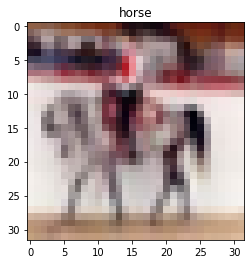

In [14]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label])

In [15]:
def preprocess_image(image, label, image_size=32):
  return tf.cast(image, tf.float32), label

In [37]:
preprocessed_image = preprocess_image(image, label)[0]
preprocessed_image.shape
#x = data_augmentation(preprocessed_image)
#x.shape

TensorShape([32, 32, 3])

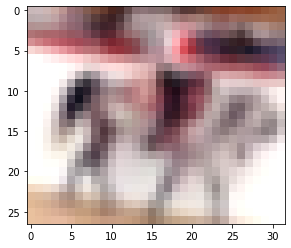

In [34]:
#preprocessed_image = preprocessed_image/225
plt.imshow(x/225)

In [18]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [19]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.float32, tf.int64)>)

In [20]:
from helper_functions import create_tensorboard_callback

checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = "val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True)

In [38]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.Resizing(32, 32)
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [39]:
from tensorflow.keras import layers

input_shape = (32, 32, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape = input_shape, name="input_shape", dtype=tf.float32)
x = data_augmentation(inputs)
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(10)(x)
outputs = layers.Activation("softmax",dtype=tf.float32)(x)
model = tf.keras.Model(inputs, outputs)

In [40]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [41]:
history = model.fit(train_data,
                    epochs=10,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.25 * len(test_data)),
                    callbacks=[model_checkpoint])

Epoch 1/10
1563/1563 [==============================] - 101s 61ms/step - loss: 1.5081 - accuracy: 0.4732 - val_loss: 1.3398 - val_accuracy: 0.5325
Epoch 2/10
1563/1563 [==============================] - 98s 63ms/step - loss: 1.3016 - accuracy: 0.5444 - val_loss: 1.2851 - val_accuracy: 0.5533
Epoch 3/10
1563/1563 [==============================] - 93s 59ms/step - loss: 1.2432 - accuracy: 0.5630 - val_loss: 1.2278 - val_accuracy: 0.5689
Epoch 4/10
1563/1563 [==============================] - 95s 60ms/step - loss: 1.2078 - accuracy: 0.5758 - val_loss: 1.2244 - val_accuracy: 0.5633
Epoch 5/10
1563/1563 [==============================] - 95s 61ms/step - loss: 1.1840 - accuracy: 0.5836 - val_loss: 1.1984 - val_accuracy: 0.5797
Epoch 6/10
1563/1563 [==============================] - 97s 62ms/step - loss: 1.1671 - accuracy: 0.5906 - val_loss: 1.1988 - val_accuracy: 0.5765
Epoch 7/10
1563/1563 [==============================] - 96s 62ms/step - loss: 1.1521 - accuracy: 0.5950 - val_loss: 1.1956 

In [42]:
model.evaluate(test_data)

313/313 [==============================] - 20s 64ms/step - loss: 1.1831 - accuracy: 0.5818


[1.1831004619598389, 0.5817999839782715]

In [43]:
base_model.trainable = True

for layers in base_model.layers[:-10]:
  layers.trainable = False

model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics = ["accuracy"])


In [44]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [45]:
initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
finetune_history = model.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=test_data,
                             initial_epoch = 10,
                             validation_steps=int(0.25 * len(test_data)),
                             callbacks=[model_checkpoint])

Epoch 11/20
1563/1563 [==============================] - 190s 117ms/step - loss: 1.0971 - accuracy: 0.6118 - val_loss: 1.0863 - val_accuracy: 0.6130
Epoch 12/20
1563/1563 [==============================] - 181s 116ms/step - loss: 0.9978 - accuracy: 0.6468 - val_loss: 1.0863 - val_accuracy: 0.6070
Epoch 13/20
1563/1563 [==============================] - 182s 116ms/step - loss: 0.9304 - accuracy: 0.6708 - val_loss: 1.0415 - val_accuracy: 0.6298
Epoch 14/20
1563/1563 [==============================] - 182s 116ms/step - loss: 0.8736 - accuracy: 0.6908 - val_loss: 1.0301 - val_accuracy: 0.6374
Epoch 15/20
1563/1563 [==============================] - 180s 115ms/step - loss: 0.8182 - accuracy: 0.7102 - val_loss: 1.0388 - val_accuracy: 0.6362
Epoch 16/20
1563/1563 [==============================] - 180s 115ms/step - loss: 0.7689 - accuracy: 0.7280 - val_loss: 1.0452 - val_accuracy: 0.6414
Epoch 17/20
1563/1563 [==============================] - 183s 117ms/step - loss: 0.7174 - accuracy: 0.7476

In [46]:
model.evaluate(test_data)

313/313 [==============================] - 17s 55ms/step - loss: 1.1271 - accuracy: 0.6366


[1.127070426940918, 0.6366000175476074]

In [47]:
model.save('my_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
